In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from IPython.display import display, Markdown

In [3]:
import lfpreg, batchreg

In [4]:
lfpdata = Path("~/neuropixel/data/LFP_registration_shared/").expanduser()

In [5]:
def showrasters(raw, lfp, csd):
    fig, (aa, ab, ac) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    aa.imshow(raw, aspect=0.25 * raw.shape[1] / raw.shape[0])
    ab.imshow(lfp, aspect=0.25 * lfp.shape[1] / lfp.shape[0])    
    ac.imshow(csd, aspect=0.25 * csd.shape[1] / csd.shape[0])
    aa.set_ylabel("raw lfp")
    ab.set_ylabel("lfp raster")
    ac.set_ylabel("csd raster")
    ac.set_xlabel("time")

In [6]:
subsamp = 5
thresholds = {"pt01": 0.7, "pt02": 0.7, "pt03": 0.7, "pt04": 0.9}

In [27]:
names = []
plfps = []
pcsds = []
tends = []

for f in sorted(lfpdata.glob("pt02*")):
    lfpf = list(f.glob("*LFP.mat"))[0]
    chanmapf = list(f.glob("*ChanMap.mat"))[0]
    ptstr = lfpf.name.split("_")[0]
    display(Markdown(f"## {ptstr}"))
    
    # load a chunk of data
    chanmap = loadmat(chanmapf)
    geom = np.c_[chanmap["xcoords"], chanmap["ycoords"]]
    lfpf = loadmat(lfpf)
    raw = lfpf["LFPMatrix"]
    D, T = raw.shape
    tend = T // 20
    print(tend)
    raw = raw[:, tend:tend*2]
    chans = range(0, raw.shape[0])
    if "channels_in_brain" in lfpf:
        chans = (lfpf["channels_in_brain"].astype(int) - 1).ravel()
        chans = range(chans[0], chans[1])
    
    # register
    plfp = batchreg.batch_register_rigid(raw, geom, csd=False, mincorr=thresholds[ptstr])
    pcsd = batchreg.batch_register_rigid(raw, geom, csd=True, mincorr=thresholds[ptstr])
    
    names.append(ptstr)
    plfps.append(plfp)
    pcsds.append(pcsd)
    tends.append(tend)


## pt02

109125
C 384 T 109125 T_ds 21825


batches:   0%|          | 0/4 [00:00<?, ?it/s]

Build matrices... took 0.1396961212158203 s
Kronecker start
lsqr problem shape (1881506, 21825) (1881506,)
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 1881506 rows and 21825 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =    21825

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  5.622e+04  1.436e+06   1.0e+00  4.5e-04
     1  0.00000e+00  4.149e+04  5.782e+05   7.4e-01  3.7e-01  3.7e+01  1.0e+00
     2  0.00000e+00  3.818e+04  2.929e+05   6.8e-01  1.3e-01  5.7e+01  1.1e+00
     3  0.00000e+00  3.686e+04  1.982e+05   6.6e-01  7.7e-02  7.0e+01  1.5e+00
     4  0.00000e+00  3.594e+04  1.370e+05   6.4e-01  4.6e-02  8.2e+01  1.7e+00
     5  0.00000e+00  3.542e+04  1.081e+05   6.3e-01  3.4e-02  9.1e+01  2.0e+00
     6  0.00000e+00  3.492e+04  8.139e+04   6.2e-01  2.3e-02  1.0e+02  2.1e+00
     7  0.00000e+00  3.466e+04  6.835e+04   6.2e

batches:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/charlie/neuropixelsLFPregistration/python/pixelCSD.py:35: RuntimeWarning: Mean of empty slice
  mean_CSD = np.nanmean(CSD, 2)


KeyboardInterrupt: 

## pt01, $T=104125$

(20825,) (20825,)
orig (384, 20825) (20825,) (20825,) 104125 20825
reg a
reg b


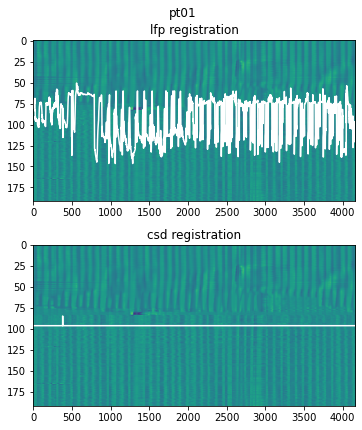

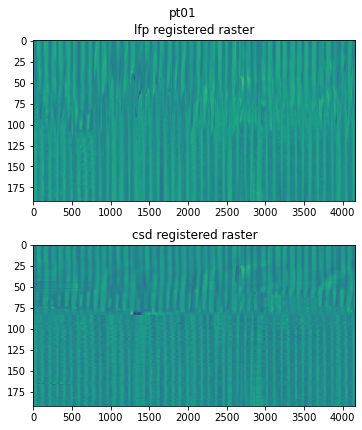

In [24]:
for n, plfp, pcsd, tend, fn in zip(names, plfps, pcsds, tends, sorted(lfpdata.glob("pt02*"))):
    display(Markdown(f"## {n}, $T={tend}$"))
    
    lfpf = list(fn.glob("*LFP.mat"))[0]
    chanmapf = list(fn.glob("*ChanMap.mat"))[0]
    
    print(plfp.shape, pcsd.shape)
    
    # load a chunk of data
    chanmap = loadmat(chanmapf)
    geom = np.c_[chanmap["xcoords"], chanmap["ycoords"]]
    lfpf = loadmat(lfpf)
    raw = lfpf["LFPMatrix"]
    D, T = raw.shape
    raw = raw[:, :tend:subsamp]
    print("orig", raw.shape, plfp.shape, pcsd.shape, tend, tend // subsamp)
    chans = range(0, raw.shape[0])
    if "channels_in_brain" in lfpf:
        chans = (lfpf["channels_in_brain"].astype(int) - 1).ravel()
        chans = range(chans[0], chans[1])
    
    plot_subsamp = 5
    raw = raw[:, ::plot_subsamp]
    plfp = plfp[::plot_subsamp]
    pcsd = pcsd[::plot_subsamp]
    
        
    # get raster
    rss = lfpreg.lfpraster(raw, geom, channels=chans)
    print("reg a", flush=True)
    rsslfpreg = lfpreg.rigid_registered_raster(rss, plfp)
    print("reg b", flush=True)
    rsscsdreg = lfpreg.rigid_registered_raster(rss, pcsd)
    
    
    # vis a section
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(rss, aspect=0.5 * rss.shape[1] / rss.shape[0])
    ab.imshow(rss, aspect=0.5 * rss.shape[1] / rss.shape[0])
    aa.plot(rss.shape[0] / 2 + plfp, c="w")
    ab.plot(rss.shape[0] / 2 + pcsd, c="w")
    aa.set_title("lfp registration")
    ab.set_title("csd registration")
    fig.suptitle(n)
    fig.tight_layout(pad=0.5)
    plt.show()
    
    # plot registered rasters
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(rsslfpreg, aspect=0.5 * rsslfpreg.shape[1] / rsslfpreg.shape[0])
    ab.imshow(rsscsdreg, aspect=0.5 * rsscsdreg.shape[1] / rsscsdreg.shape[0])
    aa.set_title("lfp registered raster")
    ab.set_title("csd registered raster")
    fig.suptitle(n)
    fig.tight_layout(pad=0.5)
    plt.show()

## pt01, $T=104125$

orig (384, 20825) (20825,) (20825,) 104125 20825
5206
reg a
reg b


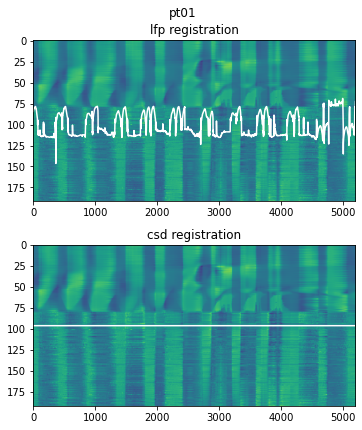

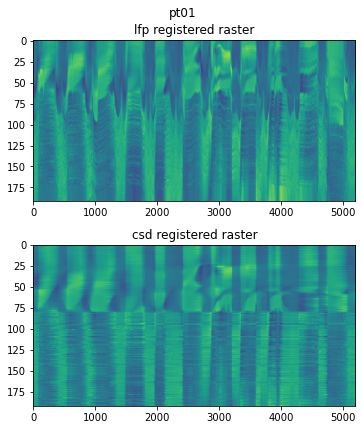

In [22]:
for n, plfp, pcsd, tend, fn in zip(names, plfps, pcsds, tends, sorted(lfpdata.glob("pt01*"))):
    display(Markdown(f"## {n}, $T={tend}$"))
    
    lfpf = list(fn.glob("*LFP.mat"))[0]
    chanmapf = list(fn.glob("*ChanMap.mat"))[0]
    
    # load a chunk of data
    chanmap = loadmat(chanmapf)
    geom = np.c_[chanmap["xcoords"], chanmap["ycoords"]]
    lfpf = loadmat(lfpf)
    raw = lfpf["LFPMatrix"]
    D, T = raw.shape
    raw = raw[:, :tend:subsamp]
    print("orig", raw.shape, plfp.shape, pcsd.shape, tend, tend // subsamp)
    chans = range(0, raw.shape[0])
    if "channels_in_brain" in lfpf:
        chans = (lfpf["channels_in_brain"].astype(int) - 1).ravel()
        chans = range(chans[0], chans[1])
    
    plot_start = raw.shape[1] // 2
    plot_end = 3 * raw.shape[1] // 4
    print(plot_end - plot_start)
    
    raw = raw[:, plot_start:plot_end]
    plfp = plfp[plot_start:plot_end]
    pcsd = pcsd[plot_start:plot_end]
    
        
    # get raster
    rss = lfpreg.lfpraster(raw, geom, channels=chans)
    print("reg a", flush=True)
    rsslfpreg = lfpreg.rigid_registered_raster(rss, plfp)
    print("reg b", flush=True)
    rsscsdreg = lfpreg.rigid_registered_raster(rss, pcsd)
    
    
    # vis a section
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(rss, aspect=0.5 * rss.shape[1] / rss.shape[0])
    ab.imshow(rss, aspect=0.5 * rss.shape[1] / rss.shape[0])
    aa.plot(rss.shape[0] / 2 + plfp, c="w")
    ab.plot(rss.shape[0] / 2 + pcsd, c="w")
    aa.set_title("lfp registration")
    ab.set_title("csd registration")
    fig.suptitle(n)
    fig.tight_layout(pad=0.5)
    plt.show()
    
    # plot registered rasters
    fig, (aa, ab) = plt.subplots(2, 1, figsize=(5, 6))
    aa.imshow(rsslfpreg, aspect=0.5 * rsslfpreg.shape[1] / rsslfpreg.shape[0])
    ab.imshow(rsscsdreg, aspect=0.5 * rsscsdreg.shape[1] / rsscsdreg.shape[0])
    aa.set_title("lfp registered raster")
    ab.set_title("csd registered raster")
    fig.suptitle(n)
    fig.tight_layout(pad=0.5)
    plt.show()